In [ ]:
!pip install -q 'tensorflow-text==2.11.*'
!pip install -q tensorflow_datasets
!pip install -q einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 27.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.10 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.

In [ ]:
 !pip uninstall protobuf -y


Found existing installation: protobuf 4.25.5
Uninstalling protobuf-4.25.5:
  Successfully uninstalled protobuf-4.25.5


In [ ]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
pandas-gbq 0.24.0 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tensorflow 2.11.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import collections
import time
import string
import re
import einops
from tqdm.auto import tqdm
from PIL import Image
import nltk
from nltk.util import ngrams

import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_datasets as tfds

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def get_data(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

def get_dataset(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')
    captions = (path/'Flickr8k.token.txt').read_text().splitlines()
    captions = [cap.split('\t') for cap in captions]
    captions = [(img_path.split('#')[0], cap) for (img_path, cap) in captions]
    cap_dict = collections.defaultdict(list)
    for img_path, cap in captions:
        cap_dict[img_path].append(cap)

    train_imgs_path = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
    test_imgs_path = (path/'Flickr_8k.testImages.txt').read_text().splitlines()

    train_caps = [(str(path/'Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in train_imgs_path]
    test_caps = [(str(path/'Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in test_imgs_path]

    train_raw = tf.data.experimental.from_list(train_caps)
    test_raw = tf.data.experimental.from_list(test_caps)

    return train_raw, test_raw

In [ ]:
get_data()
train_raw, test_raw = get_dataset()

2340801/2340801 [==============================] - 0s 0us/step


In [ ]:
print(len(train_raw), len(test_raw))
print(train_raw.element_spec)

for img_path, captions in train_raw.take(1):
    break

print(img_path)
print(captions)

6000 1000
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.string, name=None))
tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Define the image shape
image_shape = (224, 224, 3)

# Use EfficientNetB0 for feature extraction
feature_extractor = EfficientNetB0(
    input_shape=image_shape,
    weights='imagenet',
    include_top=False
)
feature_extractor.trainable = False


16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, image_shape[:-1])
    return img

In [ ]:
img = load_img(img_path.numpy().decode('utf-8'))
print(img.shape)
print(feature_extractor(img[tf.newaxis, ...]).shape)

(224, 224, 3)
(1, 7, 7, 1280)


In [ ]:
def standardize(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, f'[{re.escape(string.punctuation)}]', '')
    text = tf.strings.join(['[START]',text,'[END]'], separator = ' ')
    return text

In [ ]:
standardize('A black dog is running after a white dog in the snow .')

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] a black dog is running after a white dog in the snow  [END]'>

In [ ]:
vocab_size = 5000
vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                               standardize = standardize,
                                               ragged = True)

vectorizer.adapt(train_raw.map(lambda img_path, cap: cap).unbatch().batch(1024))

In [ ]:
print(vectorizer.get_vocabulary()[:10])

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']


In [ ]:
text_to_id_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '')
id_to_text_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '', invert = True)

In [ ]:
def id_to_text(token_ids, reserved_tokens=['', '[UNK]', '[START]', '[END]', '0']):
    """
    Convert token IDs to readable text, ignoring reserved tokens and padding.

    Args:
    - token_ids: Tensor of token IDs (sequence).
    - reserved_tokens: List of tokens to ignore.

    Returns:
    - Decoded caption as a string.
    """
    # Convert token IDs to words
    words = id_to_text_vectorizer(token_ids)  # Shape: (sequence_length,)

    # Handle filtering reserved tokens
    if reserved_tokens:
        reserved_tokens_re = '|'.join(map(re.escape, reserved_tokens))
        mask = ~tf.strings.regex_full_match(words, reserved_tokens_re)
        if mask.shape.rank == 1 and words.shape.rank == 1:
            words = tf.ragged.boolean_mask(words, mask)

    # Check for empty captions and return a placeholder if empty
    if tf.size(words) == 0:
        return tf.constant("EMPTY_CAPTION", dtype=tf.string)

    # Join the words into a sentence
    sentence = tf.strings.reduce_join(words, axis=-1, separator=' ')
    return sentence



def serialize_data(images, captions):
    captions_shape = einops.parse_shape(captions, 'b c')
    captions = einops.rearrange(captions, 'b c -> (b c)')
    images = einops.repeat(images, 'b ...  -> (b c) ...', c = captions_shape['c'])
    return images, captions

In [ ]:
for img, cap in train_raw.batch(1024).take(1):
    break

print(img.shape)
print(cap.shape)
img_serialize, cap_serialize = serialize_data(img, cap)
print(img_serialize.shape, cap_serialize.shape)

(1024,)
(1024, 5)
(5120,) (5120,)


In [ ]:
def prepare_batch(img, cap):
    cap_tokenized = vectorizer(cap)
    cap_tokenized_in = cap_tokenized[:, :-1]
    cap_tokenized_out = cap_tokenized[:, 1:]

    return (img, cap_tokenized_in.to_tensor()), cap_tokenized_out.to_tensor()

In [ ]:
def save_dataset(raw_ds, file_path, image_feature_extractor, vectorizer, shards = 20, batch_size = 64):
    raw_ds = (raw_ds
              .map(lambda img_path, cap: (load_img(img_path), cap), tf.data.AUTOTUNE)
              .batch(batch_size))

    def gen():
        for (img, cap) in tqdm(raw_ds):
            img_features = image_feature_extractor(img)
            img_features, cap = serialize_data(img_features, cap)

            yield img_features, cap

    ds = tf.data.Dataset.from_generator(gen,
                                        output_signature = (
                                            tf.TensorSpec(shape = image_feature_extractor.output_shape),
                                            tf.TensorSpec(shape = (None,), dtype = tf.string)
                                        ))

    ds = (ds
          .map(prepare_batch, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(1000))
b
    def shard_func(i, data):
        return i % shards

    ds.enumerate().save(file_path, shard_func = shard_func)

In [ ]:
%%time
save_dataset(train_raw, 'train_cache', feature_extractor, vectorizer)
save_dataset(test_raw, 'test_cache', feature_extractor, vectorizer)

  0%|          | 0/94 [00:01<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 8min 52s, sys: 7min 49s, total: 16min 41s
Wall time: 16min 43s


In [ ]:
def load_dataset(file_path, batch_size = 64, cycle_length = 2):
    def reader_func(ds):
        ds = ds.shuffle(1000)
        return ds.interleave(lambda x: x, cycle_length = cycle_length)

    def drop_index(i, x):
        return x

    ds = tf.data.Dataset.load(file_path, reader_func = reader_func)

    ds = (ds
          .map(drop_index)
          .shuffle(1000)
          .padded_batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))
    return ds

In [ ]:
batch_size = 64
train_ds = load_dataset('train_cache', batch_size)
test_ds = load_dataset('test_cache', batch_size)

In [ ]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

print(cap[0])
print(cap_labels[0])

(64, 7, 7, 1280)
(64, 37)
(64, 37)
tf.Tensor(
[  3  17  35  11 368   5   6 243   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0], shape=(37,), dtype=int64)
tf.Tensor(
[ 17  35  11 368   5   6 243   4   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0], shape=(37,), dtype=int64)


In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 1280), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
def positional_encoding(length, depth):
    pos = tf.cast(tf.range(length)[:, tf.newaxis], tf.float32)
    dep = tf.cast(tf.range(depth)[tf.newaxis, :], tf.float32)
    dep = ((dep // 2)*2)/tf.cast(depth, tf.float32)

    angle_rates = 1 / (10000**dep)
    angle_rads = pos*angle_rates

    out = tf.Variable(tf.zeros((length, depth)))
    out[:, 0::2].assign(tf.math.sin(angle_rads[:, 0::2]))
    out[:, 1::2].assign(tf.math.cos(angle_rads[:, 1::2]))

    return out[tf.newaxis, ...]

In [ ]:
sample_enc = positional_encoding(length = 2048, depth = 512)[0]

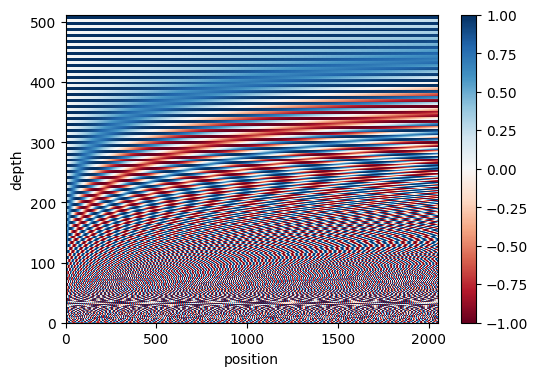

In [ ]:
plt.figure(figsize = (6, 4))
plt.pcolormesh(tf.transpose(sample_enc), cmap = 'RdBu')
plt.xlabel('position')
plt.ylabel('depth')
plt.colorbar()
plt.show();

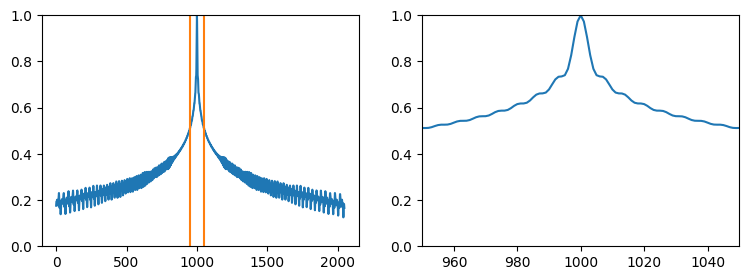

In [ ]:

p_norm = tf.linalg.l2_normalize(sample_enc[1000][tf.newaxis, :])
sample_enc_norm = tf.linalg.l2_normalize(sample_enc, axis = 1)
dots = tf.linalg.matmul(sample_enc_norm, p_norm, transpose_b = True)

plt.figure(figsize = (9, 3))
plt.subplot(1, 2, 1)
plt.plot(dots)
plt.ylim([0, 1])
plt.plot([950, 950, float('nan'), 1050, 1050], [0, 1, float('nan'), 0, 1])

plt.subplot(1, 2, 2)
plt.plot(dots)
plt.ylim([0, 1])
plt.xlim([950, 1050])
plt.show()

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero = True)
        self.pos_enc = positional_encoding(length = 2048, depth = d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x_emb = self.embedding(x)
        x_pos_enc = self.pos_enc[:, :length, :]

        x_emb *= tf.cast(self.d_model, tf.float32)
        x_emb += x_pos_enc

        return x_emb

In [ ]:
sample_pos_emb = PositionalEmbedding(vocab_size, d_model = 512)
cap_emb = sample_pos_emb(cap)
print(cap_emb.shape)

(64, 37, 512)


In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

In [ ]:
class CausalAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query = x,
                               key = x,
                               value = x,
                               use_causal_mask = True)

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [ ]:
sample_csa = CausalAttention(num_heads = 8, key_dim = 512)
sample_csa_out = sample_csa(cap_emb)
print(sample_csa_out.shape)

(64, 37, 512)


In [ ]:
class CrossAttention(BaseAttention):
    def call(self, context, x):
        attn_out, attn_scores = self.mha(query = x,
                                         key = context,
                                         value = context,
                                         return_attention_scores = True)

        self.last_attention_scores = attn_scores

        x = self.add([x, attn_out])
        x = self.layernorm(x)
        return x

In [ ]:
img_ = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img.shape, img_.shape)

sample_ca = CrossAttention(num_heads = 8, key_dim = 512)
sample_ca_out = sample_ca(context = img_, x = sample_csa_out)
print(sample_ca_out.shape)

(64, 7, 7, 1280) (64, 49, 1280)
(64, 37, 512)


In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation = 'relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(rate = dropout_rate)
        ])

        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        return x

In [ ]:
sample_ffn = FeedForward(d_model = 512, dff = 2048)
sample_ffn_out = sample_ffn(sample_ca_out)
print(sample_ffn_out.shape)

(64, 37, 512)


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads, dropout_rate = 0.1):
        super().__init__()
        self.causal_attention = CausalAttention(num_heads = num_heads,
                                                key_dim = d_model,
                                                dropout = dropout_rate)
        self.cross_attention = CrossAttention(num_heads = num_heads,
                                              key_dim = d_model,
                                              dropout = dropout_rate)
        self.ffn = FeedForward(d_model = d_model,
                               dff = dff,
                               dropout_rate = dropout_rate)
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.causal_attention(x)
        x = self.cross_attention(context = context, x = x)
        x = self.ffn(x)
        self.last_attention_scores = self.cross_attention.last_attention_scores

        return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model = 512, dff = 2048, num_heads = 8, dropout_rate = 0.2)
sample_decoder_layer_out = sample_decoder_layer(context = img_, x = cap_emb)
print(sample_decoder_layer_out.shape)

(64, 37, 512)


In [ ]:
class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, vocab, bad_tokens = ('', '[UNK]', '[START]')):
        super().__init__()
        self.vocab = vocab
        self.bad_tokens = bad_tokens
        self.bias = 0
        self.dense_layer = tf.keras.layers.Dense(len(vocab), activation = tf.nn.log_softmax)

    def adapt(self, cap_ds):
        word_idx = {word : idx for idx, word in enumerate(self.vocab)}
        counts = collections.Counter()
        for tokens in cap_ds:
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros((len(self.vocab), ))
        for token_id, cnt in counts.items():
            counts_arr[token_id] = cnt

        bad_indices = np.array([word_idx[word] for word in self.bad_tokens])
        counts_arr[bad_indices] = 0

        counts_prob = counts_arr / counts_arr.sum()
        counts_prob[counts_arr == 0] = 1
        log_p = np.log(counts_prob)

        entropy = (-counts_prob*log_p).sum()

        print(f'uniform_entropy : {np.log(len(self.vocab))}')
        print(f'curr_entropy : {entropy}')
        log_p[counts_arr == 0] = -1e9

        self.bias = log_p[tf.newaxis, tf.newaxis, :]

    def call(self, x):
        return self.dense_layer(x) + self.bias

In [ ]:
vocab = vectorizer.get_vocabulary()
sample_output_layer = OutputLayer(vocab)
sample_output_layer.adapt(train_ds.map(lambda img, cap: cap))
sample_output_layer_out = sample_output_layer(sample_decoder_layer_out)
print(sample_output_layer_out.shape)

uniform_entropy : 8.517193191416238
curr_entropy : 5.292547935444457
(64, 37, 5000)


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.num_layers = num_layers

        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        self.decoder_layers = [DecoderLayer(d_model, dff, num_heads, dropout_rate) for _ in range(num_layers)]
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.positional_embedding(x)
        for i in range(self.num_layers):
            x = self.decoder_layers[i](context = context, x = x)

        self.last_attention_scores = self.decoder_layers[-1].last_attention_scores
        return x

In [ ]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

img_features = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img_features.shape)

(64, 7, 7, 1280)
(64, 37)
(64, 37)
(64, 49, 1280)


In [ ]:
%%time
sample_decoder = Decoder(num_layers = 6, num_heads = 8, d_model = 512, dff = 2048)
sample_decoder_output = sample_decoder(context = img_features, x = cap)
print(sample_decoder_output.shape)
print(sample_decoder.last_attention_scores.shape)

(64, 37, 512)
(64, 8, 37, 49)
CPU times: user 29.1 s, sys: 4.31 s, total: 33.5 s
Wall time: 21.5 s


In [ ]:
class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, vectorizer, feature_extractor, output_layer, num_layers, num_heads, d_model, dff, pred_max_len =  50, dropout_rate = 0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.vectorizer = vectorizer
        self.output_layer = output_layer
        self.decoder = Decoder(num_layers, num_heads, d_model, dff, dropout_rate)
        self.max_len = pred_max_len
        self.vocab = self.vectorizer.get_vocabulary()

    def call(self, inputs):
        context, cap = inputs
        if context.shape[-1] == 3:
            context = self.feature_extractor(context)
        context = einops.rearrange(context, 'b h w c -> b (h w) c')

        if cap.dtype == tf.string:
            cap = self.vectorizer([cap])


        x = self.decoder(context = context, x = cap)
        x = self.output_layer(x)
        return x

In [ ]:
%%time
sample_captioner = Captioner(vectorizer = vectorizer,
                             feature_extractor = feature_extractor,
                             output_layer = sample_output_layer,
                             num_layers = 6,
                             num_heads = 8,
                             d_model = 512,
                             dff = 2048,
                             dropout_rate = 0.2)

print(sample_captioner((img, cap)).shape)
print(cap_labels.shape)
print(sample_captioner.summary())

(64, 37, 5000)
(64, 37)
Model: "captioner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 text_vectorization (TextVec  multiple                 0         
 torization)                                                     
                                                                 
 output_layer (OutputLayer)  multiple                  2565000   
                                                                 
 decoder_1 (Decoder)         multiple                  153742336 
                                                                 
Total params: 160,356,907
Trainable params: 156,307,336
Non-trainable params: 4,049,571
_________________________________________________________________
None
CPU times: user 29.6 s, sys: 4.61 s, total: 34.2 s
Wall time: 21.6 s


In [ ]:
d_model = 128
dff = 128
dropout_rate = 0.4
num_layers = 2
num_heads = 2
output_layer = OutputLayer(vocab)
output_layer.adapt(train_ds.map(lambda img_feature, cap: cap))

uniform_entropy : 8.517193191416238
curr_entropy : 5.292547935444457


In [ ]:
for (img_feature, cap), cap_labels in train_ds.take(1):
    break
print(img_feature.shape)
print(cap.shape)
print(cap_labels.shape)

(64, 7, 7, 1280)
(64, 34)
(64, 34)


In [ ]:
%%time
captioner_model = Captioner(vectorizer = vectorizer,
                            feature_extractor = feature_extractor,
                            output_layer = output_layer,
                            num_layers = num_layers,
                            num_heads = num_heads,
                            d_model = d_model,
                            dff = dff,
                            dropout_rate = dropout_rate)

print(captioner_model((img_feature, cap), training = False).shape)
captioner_model.summary()

(64, 34, 5000)
Model: "captioner_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 text_vectorization (TextVec  multiple                 0         
 torization)                                                     
                                                                 
 output_layer_1 (OutputLayer  multiple                 645000    
 )                                                               
                                                                 
 decoder_2 (Decoder)         multiple                  2415104   
                                                                 
Total params: 7,109,675
Trainable params: 3,060,104
Non-trainable params: 4,049,571
_________________________________________________________________
CPU times: user 957 ms

In [ ]:
@Captioner.add_method
def generate_text(self, img, temperature = 0.5):
    if img.shape[-1] == 3:
        img = self.feature_extractor(img)
    start_token = text_to_id_vectorizer([['[START]']])

    start_idx = self.vocab.index('[START]')
    end_idx = self.vocab.index('[END]')

    for i in range(self.max_len):
        preds = self((img, start_token))
        preds = preds[:, -1, :]
        if temperature == 0.0:
            pred_idx = tf.argmax(preds, axis = -1)[:, tf.newaxis]
        else:
            preds /= temperature
            pred_idx = tf.random.categorical(preds, num_samples = 1)

        start_token = tf.concat([start_token, pred_idx], axis = -1)

        if pred_idx[0][0] == end_idx:
            break

    return id_to_text(start_token).numpy()[0].decode('utf-8')

In [ ]:
def brevity_penalty(can, ref):
    can_tokens = nltk.word_tokenize(can)
    ref_tokens = nltk.word_tokenize(ref)
    if len(can_tokens) == 0:
        return 0.0
    return min(1, np.exp(1 - (len(ref_tokens) / len(can_tokens))))

def precision(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(can_n.values())

    if total == 0:
        return 0

    for n_g in can_n:
        if n_g in ref_n:
            can_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            can_n[n_g] = 0
    return sum(can_n.values()) / total

def bleu_score(can , ref, n_gram_range = 2):
    precisions = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        precisions.append(precision(can, ref, n))
    precisions = np.array(precisions)

    if 0 in precisions:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(precisions).mean())

def recall(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(ref_n.values())

    if total == 0:
        return 0

    for n_g in ref_n:
        if n_g in can_n:
            ref_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            ref_n[n_g] = 0
    return sum(ref_n.values()) / total

def rouge_score(can , ref, n_gram_range = 2):
    recalls = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        recalls.append(recall(can, ref, n))
    recalls = np.array(recalls)

    if 0 in recalls:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(recalls).mean())

In [ ]:
@Captioner.add_method
def f_score(self, can, refs, n_gram_range = 1):
    b_scores = [bleu_score(can, ref, n_gram_range) for ref in refs]
    r_scores = [rouge_score(can, ref, n_gram_range)  for ref in refs]
    f_vals = []
    for b_score, r_score in zip(b_scores, r_scores):
        if b_score + r_score == 0:
            return 0
        f_vals.append((2*b_score*r_score) / (b_score + r_score))

    return max(f_vals)

In [ ]:
def masked_loss(labels, preds):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
    loss = tf.cast(loss_fn(labels, preds), tf.float32)
    mask = ((labels != 0) & (loss < 1e8))
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return tf.math.reduce_sum(loss) / tf.math.reduce_sum(mask)

def masked_accuracy(labels, preds):
    preds = tf.cast(tf.argmax(preds, axis = -1), tf.float32)
    labels = tf.cast(labels, tf.float32)
    mask = tf.cast(labels != 0, tf.float32)
    acc = tf.cast(preds == labels, tf.float32)
    acc *= mask
    return tf.math.reduce_sum(acc) / tf.math.reduce_sum(mask)

In [ ]:
for (img, cap), cap_labels in train_ds.take(1):
    break
print(img.shape)
print(cap.shape)
print(cap_labels.shape)

preds = captioner_model((img, cap))
print(preds.shape)

print(masked_loss(cap, preds))
print(masked_accuracy(cap, preds))

(64, 7, 7, 1280)
(64, 37)
(64, 37)
(64, 37, 5000)
tf.Tensor(5.5360823, shape=(), dtype=float32)
tf.Tensor(0.13216957, shape=(), dtype=float32)


tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
(224, 224, 3)
['A black dog is running after a white dog in the snow .', 'Black dog chasing brown dog through snow', 'Two dogs chase each other across the snowy ground .', 'Two dogs play together in the snow .', 'Two dogs running through a low lying body of water .']


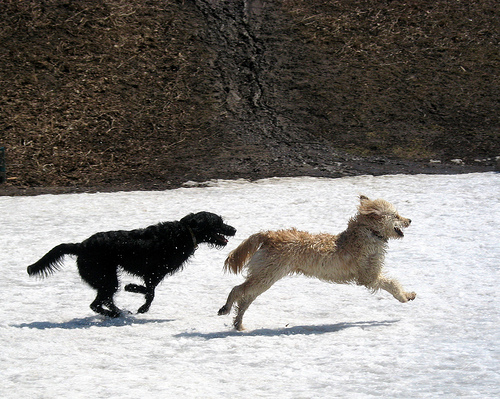

In [ ]:

for img_path, caps in train_raw.take(1):
    break
print(img_path)
img = load_img(img_path)
print(img.shape)
caps = [cap.numpy().decode('utf-8') for cap in caps]
print(caps)
Image.open(img_path.numpy().decode('utf-8'))

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self, img = img):
        self.image = img[tf.newaxis, ...]
        self.caps = caps

    def on_epoch_end(self, epochs = None, logs = None):
        print('\n')
        for temp in (0, 0.5, 1):
            gen_text = self.model.generate_text(self.image)
            f_val = self.model.f_score(gen_text, self.caps, n_gram_range = 1)
            print(f'Generated_text: {gen_text}, \t f_score: {f_val}')

In [ ]:
sample_gen_text = GenerateText()
sample_gen_text.model = captioner_model
sample_gen_text.on_epoch_end(0)



Generated_text: man, 	 f_score: 0
Generated_text: a the a a in a a a the a a, 	 f_score: 0
Generated_text: a man a a a, 	 f_score: 0


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
callbacks = [GenerateText(),
             tf.keras.callbacks.EarlyStopping(patience = 6, restore_best_weights = True)]

In [ ]:
captioner_model.compile(loss = masked_loss, optimizer = optimizer, metrics = [masked_accuracy])

In [ ]:
hist = captioner_model.fit(
    train_ds.repeat(),
    steps_per_epoch = 70,
    validation_data = test_ds.repeat(),
    validation_steps = 20,
    epochs = 100,
    callbacks = callbacks
)

Epoch 1/100
70/70 [==============================] - ETA: 0s - loss: 5.1325 - masked_accuracy: 0.1647

Generated_text: a young a man and a cellphone, 	 f_score: 0
Generated_text: a is a in a is with a dog with a, 	 f_score: 0
Generated_text: a on a in the in a a dog, 	 f_score: 0.23529411764705882
70/70 [==============================] - 92s 1s/step - loss: 5.1325 - masked_accuracy: 0.1647 - val_loss: 4.8939 - val_masked_accuracy: 0.2048
Epoch 2/100
70/70 [==============================] - ETA: 0s - loss: 4.8675 - masked_accuracy: 0.2180

Generated_text: a dog in the man, 	 f_score: 0.16886511879816196
Generated_text: a of a dog running in a dog, 	 f_score: 0
Generated_text: a playing street, 	 f_score: 0
70/70 [==============================] - 78s 1s/step - loss: 4.8675 - masked_accuracy: 0.2180 - val_loss: 4.6575 - val_masked_accuracy: 0.2378
Epoch 3/100
70/70 [==============================] - ETA: 0s - loss: 4.7052 - masked_accuracy: 0.2384

Generated_text: a dog is man in the in 

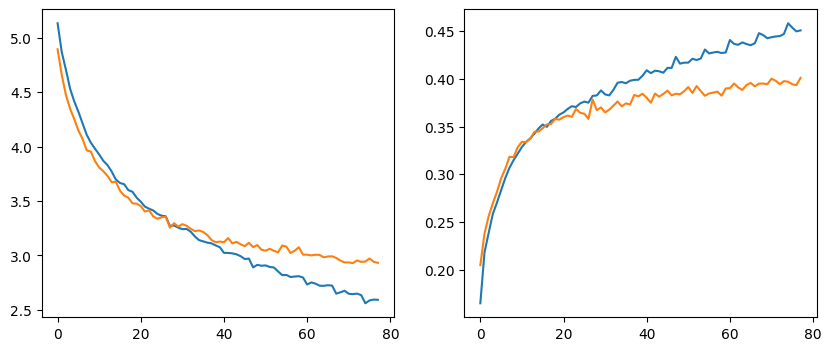

In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['masked_accuracy'], label = 'masked_accuracy')
plt.plot(hist.history['val_masked_accuracy'], label = 'val_masked_accuracy')
plt.show()

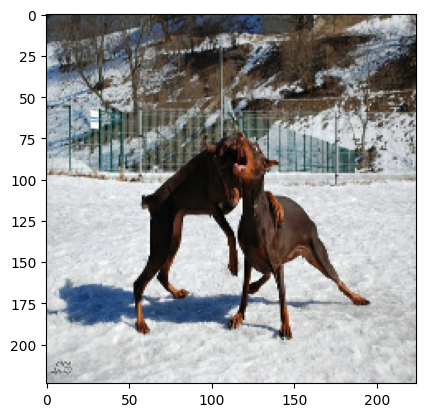

Generated Caption: [START] two brown dogs are running in the snow [END]


In [ ]:
for img_path, caps in test_raw.batch(4).take(1):
    break

img = load_img(img_path[0].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

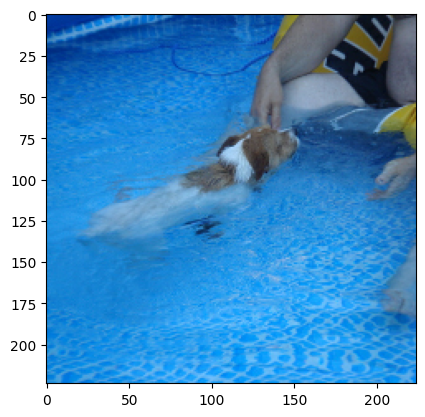

Generated Caption: [START] a dog jumps into a pool [END]


In [ ]:
img = load_img(img_path[1].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

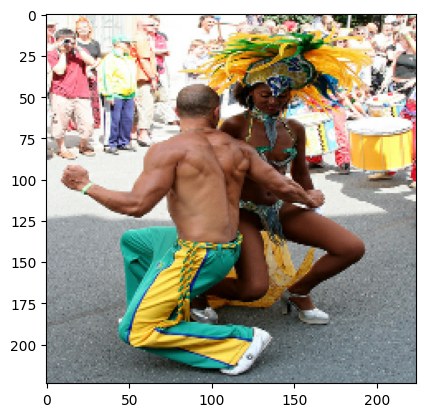

Generated Caption: [START] a shirtless man and a woman wearing a blue jeans and white uniform are standing in a yellow shirt and blue and blue shirts [END]


In [ ]:
img = load_img(img_path[2].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

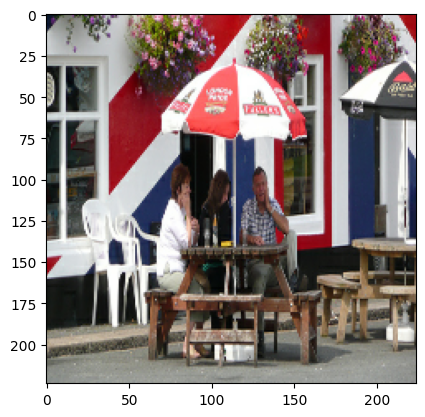

Generated Caption: [START] a man is sitting on a bench at a man with a man in the beer [END]


In [ ]:
img = load_img(img_path[3].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

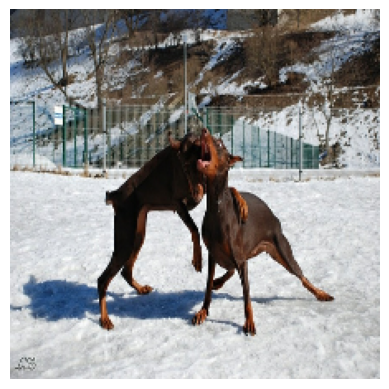

[START] two brown dogs are playing with a tennis ball in the snow [END]


In [ ]:
for img_path, cap in test_raw.take(1):
    break
img = load_img(img_path)
cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])

plt.imshow(img/255)
plt.axis('off')
plt.show()
print(cap_gen)

In [ ]:
cap_gen_tokens = cap_gen.split() + ['[END]']
print(len(cap_gen_tokens))

12


In [ ]:
attn_scores = captioner_model.decoder.last_attention_scores
print(attn_scores.shape)
attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')
print(attn_maps.shape)

(1, 2, 12, 49)
(12, 7, 7)


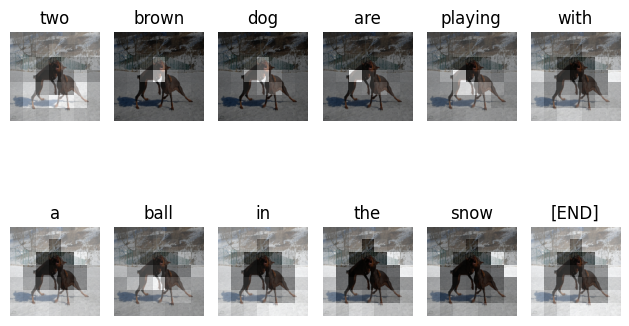

In [ ]:
len_result = len(attn_maps)
col_len = int(np.ceil(len_result/2))
row_len = 2

for i in range(len_result):
    ax = plt.subplot(row_len, col_len, i+1)
    img_plot = ax.imshow(img/255)
    plt.title(cap_gen_tokens[i])
    ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
@Captioner.add_method
def show_attention(self, img, temperature = 0.5):
    gen_text = self.generate_text(img = img[tf.newaxis, ...], temperature = temperature)
    cap_gen_tokens = cap_gen.split() + ['[END]']
    # Here we are adding [END] token as while printing text using id_to_text, it filters out [END] token even though it is generated.
    attn_scores = captioner_model.decoder.last_attention_scores
    attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')

    len_result = len(attn_maps)
    col_len = int(np.ceil(len_result/2))
    row_len = 2

    for i in range(len_result):
        ax = plt.subplot(row_len, col_len, i+1)
        img_plot = ax.imshow(img/255)
        plt.title(cap_gen_tokens[i])
        ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
        plt.axis('off')

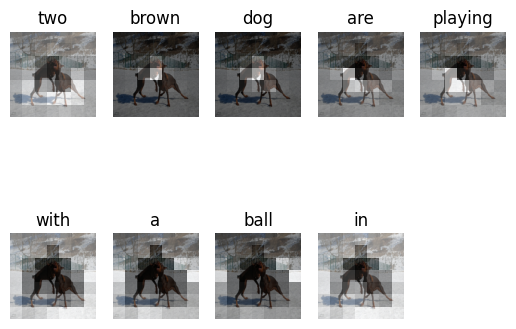

In [ ]:
captioner_model.show_attention(img)

In [ ]:

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(candidate, references, max_n=4):
    """
    Calculate BLEU-1, BLEU-2, BLEU-3, and BLEU-4 scores.

    Args:
    - candidate (str): Generated caption.
    - references (list of str): List of reference captions.
    - max_n (int): Maximum n-gram length to consider for BLEU.

    Returns:
    - dict: BLEU scores for n-grams from 1 to max_n.
    """
    # Tokenize the candidate and references
    candidate_tokens = nltk.word_tokenize(candidate)
    references_tokens = [nltk.word_tokenize(ref) for ref in references]

    # Define smoothing function
    smoothing = SmoothingFunction().method1

    # Calculate BLEU scores for n-grams
    bleu_scores = {}
    for n in range(1, max_n + 1):
        weights = tuple((1/n if i < n else 0) for i in range(max_n))
        score = sentence_bleu(references_tokens, candidate_tokens, weights=weights, smoothing_function=smoothing)
        bleu_scores[f'BLEU-{n}'] = score

    return bleu_scores

# Example Usage:
candidate_caption = "a black dog is running through the snow"
reference_captions = [
    "a dog is running in the snow",
    "black dog runs through the snow",
    "a dog plays in the snow"
]

# Get BLEU scores
bleu_results = calculate_bleu(candidate_caption, reference_captions)
print("BLEU Scores:", bleu_results)


BLEU Scores: {'BLEU-1': 1.0, 'BLEU-2': 0.8451542547285166, 'BLEU-3': 0.6197980942410934, 'BLEU-4': 0.2626909894424158}


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf
import numpy as np

# Ensure necessary NLTK resources are available
nltk.download('punkt')

def calculate_bleu(candidate, references, max_n=4):
    """
    Calculate BLEU-1, BLEU-2, BLEU-3, and BLEU-4 scores.

    Args:
    - candidate (str): Generated caption.
    - references (list of str): List of reference captions.
    - max_n (int): Maximum n-gram length to consider for BLEU.

    Returns:
    - dict: BLEU scores for n-grams from 1 to max_n.
    """
    # Tokenize the candidate and references
    candidate_tokens = nltk.word_tokenize(candidate)
    references_tokens = [nltk.word_tokenize(ref) for ref in references]

    # Define smoothing function
    smoothing = SmoothingFunction().method1

    # Calculate BLEU scores for n-grams
    bleu_scores = {}
    for n in range(1, max_n + 1):
        weights = tuple((1/n if i < n else 0) for i in range(max_n))
        score = sentence_bleu(references_tokens, candidate_tokens, weights=weights, smoothing_function=smoothing)
        bleu_scores[f'BLEU-{n}'] = score

    return bleu_scores

def evaluate_model_on_test_data(model, test_data, num_samples=5):
    """
    Evaluate the model on a few samples from the test dataset using BLEU scores.

    Args:
    - model: The trained image captioning model (Captioner).
    - test_data: The test dataset (tf.data.Dataset).
    - num_samples: Number of test samples to evaluate.

    Returns:
    - None (prints BLEU scores for each sample).
    """
    # Placeholder to store BLEU scores
    all_bleu_scores = []

    # Iterate over a few samples from the test dataset
    for (img_path, actual_captions) in test_data.take(num_samples):
        # Load and preprocess the image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))  # Ensure the size matches your model input
        img = img[tf.newaxis, ...]  # Add batch dimension

        # Generate caption using the model
        generated_caption = model.generate_text(img)

        # Decode reference captions to list of strings
        references = [caption.numpy().decode('utf-8') for caption in actual_captions]

        # Calculate BLEU scores
        bleu_scores = calculate_bleu(generated_caption, references)
        all_bleu_scores.append(bleu_scores)

        # Print results
        print("\nGenerated Caption:", generated_caption)
        print("Reference Captions:", references)
        print("BLEU Scores:", bleu_scores)

    # Optional: Calculate and print average BLEU scores over all samples
    if all_bleu_scores:
        avg_bleu_scores = {f'BLEU-{i+1}': np.mean([score[f'BLEU-{i+1}'] for score in all_bleu_scores])
                           for i in range(4)}
        print("\nAverage BLEU Scores:", avg_bleu_scores)

# Example Usage:
# Assuming `captioner_model` is your trained model and `test_raw` is your test dataset
evaluate_model_on_test_data(captioner_model, test_raw, num_samples=5)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Generated Caption: [START] two brown dogs are playing with a ball in the snow [END]
Reference Captions: ['The dogs are in the snow in front of a fence .', 'The dogs play on the snow .', 'Two brown dogs playfully fight in the snow .', 'Two brown dogs wrestle in the snow .', 'Two dogs playing in the snow .']
BLEU Scores: {'BLEU-1': 0.47058823529411764, 'BLEU-2': 0.3429971702850177, 'BLEU-3': 0.19868417243179284, 'BLEU-4': 0.08651480732019924}

Generated Caption: [START] a dog is jumping in a pool [END]
Reference Captions: ['a brown and white dog swimming towards some in the pool', 'A dog in a swimming pool swims toward sombody we cannot see .', 'A dog swims in a pool near a person .', 'Small dog is paddling through the water in a pool .', 'The small brown and white dog is in the pool .']
BLEU Scores: {'BLEU-1': 0.42736665168106897, 'BLEU-2': 0.31453333915753573, 'BLEU-3': 0.20269567062096003, 'BLEU-4': 0.09370905052462922}

Generated Caption: [START] a man in a blue shirt and pink top i

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf
import numpy as np

# Ensure necessary NLTK resources are available
nltk.download('punkt')

def calculate_bleu(candidate, references, max_n=4):
    """
    Calculate BLEU-1, BLEU-2, BLEU-3, and BLEU-4 scores.

    Args:
    - candidate (str): Generated caption.
    - references (list of str): List of reference captions.
    - max_n (int): Maximum n-gram length to consider for BLEU.

    Returns:
    - list: BLEU scores for n-grams from 1 to max_n.
    """
    # Tokenize the candidate and references
    candidate_tokens = nltk.word_tokenize(candidate)
    references_tokens = [nltk.word_tokenize(ref) for ref in references]

    # Define smoothing function
    smoothing = SmoothingFunction().method1

    # Calculate BLEU scores for n-grams
    bleu_scores = []
    for n in range(1, max_n + 1):
        weights = tuple((1/n if i < n else 0) for i in range(max_n))
        score = sentence_bleu(references_tokens, candidate_tokens, weights=weights, smoothing_function=smoothing)
        bleu_scores.append(score)

    return bleu_scores

def evaluate_model_avg_bleu(model, test_data, num_samples=100):
    """
    Evaluate the model on a subset of the test dataset and calculate average BLEU scores.

    Args:
    - model: The trained image captioning model (Captioner).
    - test_data: The test dataset (tf.data.Dataset).
    - num_samples: Number of test samples to evaluate.

    Returns:
    - dict: Average BLEU scores for n-grams (1 to 4).
    """
    # Placeholder for storing BLEU scores
    all_bleu_scores = []

    # Iterate over a subset of the test dataset
    for (img_path, actual_captions) in test_data.take(num_samples):
        # Load and preprocess the image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))  # Ensure size matches model input
        img = img[tf.newaxis, ...]  # Add batch dimension

        # Generate caption using the model
        generated_caption = model.generate_text(img)

        # Decode reference captions to list of strings
        references = [caption.numpy().decode('utf-8') for caption in actual_captions]

        # Calculate BLEU scores for the generated caption
        bleu_scores = calculate_bleu(generated_caption, references)
        all_bleu_scores.append(bleu_scores)

    # Convert list of scores to a NumPy array for easier averaging
    all_bleu_scores = np.array(all_bleu_scores)

    # Calculate average BLEU scores across all samples
    avg_bleu_scores = {f'BLEU-{i+1}': np.mean(all_bleu_scores[:, i]) for i in range(all_bleu_scores.shape[1])}

    # Print the average BLEU scores
    print("\nAverage BLEU Scores:", avg_bleu_scores)
    return avg_bleu_scores

# Example Usage:
# Assuming `captioner_model` is your trained model and `test_raw` is your test dataset
evaluate_model_avg_bleu(captioner_model, test_raw, num_samples=50)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Average BLEU Scores: {'BLEU-1': 0.34203295440608394, 'BLEU-2': 0.20096395465262146, 'BLEU-3': 0.11910357471390479, 'BLEU-4': 0.0708798410534131}


{'BLEU-1': 0.34203295440608394,
 'BLEU-2': 0.20096395465262146,
 'BLEU-3': 0.11910357471390479,
 'BLEU-4': 0.0708798410534131}

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf
import numpy as np

# Ensure necessary NLTK resources are available
nltk.download('punkt')

def calculate_bleu(candidate, references, max_n=4):
    """
    Calculate BLEU-1, BLEU-2, BLEU-3, and BLEU-4 scores.

    Args:
    - candidate (str): Generated caption.
    - references (list of str): List of reference captions.
    - max_n (int): Maximum n-gram length to consider for BLEU.

    Returns:
    - list: BLEU scores for n-grams from 1 to max_n.
    """
    # Tokenize the candidate and references
    candidate_tokens = nltk.word_tokenize(candidate)
    references_tokens = [nltk.word_tokenize(ref) for ref in references]

    # Define smoothing function
    smoothing = SmoothingFunction().method1

    # Calculate BLEU scores for n-grams
    bleu_scores = []
    for n in range(1, max_n + 1):
        weights = tuple((1/n if i < n else 0) for i in range(max_n))
        score = sentence_bleu(references_tokens, candidate_tokens, weights=weights, smoothing_function=smoothing)
        bleu_scores.append(score)

    return bleu_scores

def evaluate_model_avg_bleu(model, test_data, num_samples=100):
    """
    Evaluate the model on a subset of the test dataset and calculate average BLEU scores.

    Args:
    - model: The trained image captioning model (Captioner).
    - test_data: The test dataset (tf.data.Dataset).
    - num_samples: Number of test samples to evaluate.

    Returns:
    - dict: Average BLEU scores for n-grams (1 to 4).
    """
    # Placeholder for storing BLEU scores
    all_bleu_scores = []

    # Iterate over a subset of the test dataset
    for (img_path, actual_captions) in test_data.take(num_samples):
        # Load and preprocess the image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))  # Ensure size matches model input
        img = img[tf.newaxis, ...]  # Add batch dimension

        # Generate caption using the model
        generated_caption = model.generate_text(img)

        # Decode reference captions to list of strings
        references = [caption.numpy().decode('utf-8') for caption in actual_captions]

        # Calculate BLEU scores for the generated caption
        bleu_scores = calculate_bleu(generated_caption, references)
        all_bleu_scores.append(bleu_scores)

    # Convert list of scores to a NumPy array for easier averaging
    all_bleu_scores = np.array(all_bleu_scores)

    # Calculate average BLEU scores across all samples
    avg_bleu_scores = {f'BLEU-{i+1}': np.mean(all_bleu_scores[:, i]) for i in range(all_bleu_scores.shape[1])}

    # Print the average BLEU scores
    print("\nAverage BLEU Scores:", avg_bleu_scores)
    return avg_bleu_scores

# Example Usage:
# Assuming `captioner_model` is your trained model and `test_raw` is your test dataset
evaluate_model_avg_bleu(captioner_model, test_raw, num_samples=10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Average BLEU Scores: {'BLEU-1': 0.3477188506594632, 'BLEU-2': 0.2197629759718384, 'BLEU-3': 0.11630452958551943, 'BLEU-4': 0.06269193110639505}


{'BLEU-1': 0.3477188506594632,
 'BLEU-2': 0.2197629759718384,
 'BLEU-3': 0.11630452958551943,
 'BLEU-4': 0.06269193110639505}

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf
import numpy as np

# Ensure necessary NLTK resources are available
nltk.download('punkt')

def calculate_bleu(candidate, references, max_n=4):
    """
    Calculate BLEU-1, BLEU-2, BLEU-3, and BLEU-4 scores.

    Args:
    - candidate (str): Generated caption.
    - references (list of str): List of reference captions.
    - max_n (int): Maximum n-gram length to consider for BLEU.

    Returns:
    - list: BLEU scores for n-grams from 1 to max_n.
    """
    # Tokenize the candidate and references
    candidate_tokens = nltk.word_tokenize(candidate)
    references_tokens = [nltk.word_tokenize(ref) for ref in references]

    # Define smoothing function
    smoothing = SmoothingFunction().method1

    # Calculate BLEU scores for n-grams
    bleu_scores = []
    for n in range(1, max_n + 1):
        weights = tuple((1/n if i < n else 0) for i in range(max_n))
        score = sentence_bleu(references_tokens, candidate_tokens, weights=weights, smoothing_function=smoothing)
        bleu_scores.append(score)

    return bleu_scores

def evaluate_model_avg_bleu(model, test_data, num_samples=100):
    """
    Evaluate the model on a subset of the test dataset and calculate average BLEU scores.

    Args:
    - model: The trained image captioning model (Captioner).
    - test_data: The test dataset (tf.data.Dataset).
    - num_samples: Number of test samples to evaluate.

    Returns:
    - dict: Average BLEU scores for n-grams (1 to 4).
    """
    # Placeholder for storing BLEU scores
    all_bleu_scores = []

    # Iterate over a subset of the test dataset
    for (img_path, actual_captions) in test_data.take(num_samples):
        # Load and preprocess the image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))  # Ensure size matches model input
        img = img[tf.newaxis, ...]  # Add batch dimension

        # Generate caption using the model
        generated_caption = model.generate_text(img)

        # Decode reference captions to list of strings
        references = [caption.numpy().decode('utf-8') for caption in actual_captions]

        # Calculate BLEU scores for the generated caption
        bleu_scores = calculate_bleu(generated_caption, references)
        all_bleu_scores.append(bleu_scores)

    # Convert list of scores to a NumPy array for easier averaging
    all_bleu_scores = np.array(all_bleu_scores)

    # Calculate average BLEU scores across all samples
    avg_bleu_scores = {f'BLEU-{i+1}': np.mean(all_bleu_scores[:, i]) for i in range(all_bleu_scores.shape[1])}

    # Print the average BLEU scores
    print("\nAverage BLEU Scores:", avg_bleu_scores)
    return avg_bleu_scores

# Example Usage:
# Assuming `captioner_model` is your trained model and `test_raw` is your test dataset
evaluate_model_avg_bleu(captioner_model, test_raw, num_samples=50)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Average BLEU Scores: {'BLEU-1': 0.3211331162952858, 'BLEU-2': 0.18421134005132733, 'BLEU-3': 0.10859751852012942, 'BLEU-4': 0.06568851959153353}


{'BLEU-1': 0.3211331162952858,
 'BLEU-2': 0.18421134005132733,
 'BLEU-3': 0.10859751852012942,
 'BLEU-4': 0.06568851959153353}

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf
import numpy as np

# Ensure necessary NLTK resources are available
nltk.download('punkt')

def calculate_bleu(candidate, references, max_n=4):
    """
    Calculate BLEU-1, BLEU-2, BLEU-3, and BLEU-4 scores.

    Args:
    - candidate (str): Generated caption.
    - references (list of str): List of reference captions.
    - max_n (int): Maximum n-gram length to consider for BLEU.

    Returns:
    - list: BLEU scores for n-grams from 1 to max_n.
    """
    # Tokenize the candidate and references
    candidate_tokens = nltk.word_tokenize(candidate)
    references_tokens = [nltk.word_tokenize(ref) for ref in references]

    # Define smoothing function
    smoothing = SmoothingFunction().method1

    # Calculate BLEU scores for n-grams
    bleu_scores = []
    for n in range(1, max_n + 1):
        weights = tuple((1/n if i < n else 0) for i in range(max_n))
        score = sentence_bleu(references_tokens, candidate_tokens, weights=weights, smoothing_function=smoothing)
        bleu_scores.append(score)

    return bleu_scores

def evaluate_model_avg_bleu(model, test_data, num_samples=100):
    """
    Evaluate the model on a subset of the test dataset and calculate average BLEU scores.

    Args:
    - model: The trained image captioning model (Captioner).
    - test_data: The test dataset (tf.data.Dataset).
    - num_samples: Number of test samples to evaluate.

    Returns:
    - dict: Average BLEU scores for n-grams (1 to 4).
    """
    # Placeholder for storing BLEU scores
    all_bleu_scores = []

    # Iterate over a subset of the test dataset
    for (img_path, actual_captions) in test_data.take(num_samples):
        # Load and preprocess the image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))  # Ensure size matches model input
        img = img[tf.newaxis, ...]  # Add batch dimension

        # Generate caption using the model
        generated_caption = model.generate_text(img)

        # Decode reference captions to list of strings
        references = [caption.numpy().decode('utf-8') for caption in actual_captions]

        # Calculate BLEU scores for the generated caption
        bleu_scores = calculate_bleu(generated_caption, references)
        all_bleu_scores.append(bleu_scores)

    # Convert list of scores to a NumPy array for easier averaging
    all_bleu_scores = np.array(all_bleu_scores)

    # Calculate average BLEU scores across all samples
    avg_bleu_scores = {f'BLEU-{i+1}': np.mean(all_bleu_scores[:, i]) for i in range(all_bleu_scores.shape[1])}

    # Print the average BLEU scores
    print("\nAverage BLEU Scores:", avg_bleu_scores)
    return avg_bleu_scores

# Example Usage:
# Assuming `captioner_model` is your trained model and `test_raw` is your test dataset
evaluate_model_avg_bleu(captioner_model, test_raw, num_samples=200)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Average BLEU Scores: {'BLEU-1': 0.3293805033220164, 'BLEU-2': 0.1929034286364106, 'BLEU-3': 0.10850980218137414, 'BLEU-4': 0.0649369240488858}


{'BLEU-1': 0.3293805033220164,
 'BLEU-2': 0.1929034286364106,
 'BLEU-3': 0.10850980218137414,
 'BLEU-4': 0.0649369240488858}

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf
import numpy as np

# Ensure necessary NLTK resources are available
nltk.download('punkt')

def calculate_bleu(candidate, references, max_n=4):
    """
    Calculate BLEU-1, BLEU-2, BLEU-3, and BLEU-4 scores.

    Args:
    - candidate (str): Generated caption.
    - references (list of str): List of reference captions.
    - max_n (int): Maximum n-gram length to consider for BLEU.

    Returns:
    - list: BLEU scores for n-grams from 1 to max_n.
    """
    # Tokenize the candidate and references
    candidate_tokens = nltk.word_tokenize(candidate)
    references_tokens = [nltk.word_tokenize(ref) for ref in references]

    # Define smoothing function
    smoothing = SmoothingFunction().method1

    # Calculate BLEU scores for n-grams
    bleu_scores = []
    for n in range(1, max_n + 1):
        weights = tuple((1/n if i < n else 0) for i in range(max_n))
        score = sentence_bleu(references_tokens, candidate_tokens, weights=weights, smoothing_function=smoothing)
        bleu_scores.append(score)

    return bleu_scores

def evaluate_model_avg_bleu(model, test_data, num_samples=100):
    """
    Evaluate the model on a subset of the test dataset and calculate average BLEU scores.

    Args:
    - model: The trained image captioning model (Captioner).
    - test_data: The test dataset (tf.data.Dataset).
    - num_samples: Number of test samples to evaluate.

    Returns:
    - dict: Average BLEU scores for n-grams (1 to 4).
    """
    # Placeholder for storing BLEU scores
    all_bleu_scores = []

    # Iterate over a subset of the test dataset
    for (img_path, actual_captions) in test_data.take(num_samples):
        # Load and preprocess the image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))  # Ensure size matches model input
        img = img[tf.newaxis, ...]  # Add batch dimension

        # Generate caption using the model
        generated_caption = model.generate_text(img)

        # Decode reference captions to list of strings
        references = [caption.numpy().decode('utf-8') for caption in actual_captions]

        # Calculate BLEU scores for the generated caption
        bleu_scores = calculate_bleu(generated_caption, references)
        all_bleu_scores.append(bleu_scores)

    # Convert list of scores to a NumPy array for easier averaging
    all_bleu_scores = np.array(all_bleu_scores)

    # Calculate average BLEU scores across all samples
    avg_bleu_scores = {f'BLEU-{i+1}': np.mean(all_bleu_scores[:, i]) for i in range(all_bleu_scores.shape[1])}

    # Print the average BLEU scores
    print("\nAverage BLEU Scores:", avg_bleu_scores)
    return avg_bleu_scores

# Example Usage:
# Assuming `captioner_model` is your trained model and `test_raw` is your test dataset
evaluate_model_avg_bleu(captioner_model, test_raw, num_samples=500)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Average BLEU Scores: {'BLEU-1': 0.32930031200339954, 'BLEU-2': 0.19632404183246377, 'BLEU-3': 0.11114401850068785, 'BLEU-4': 0.06581722528264007}


{'BLEU-1': 0.32930031200339954,
 'BLEU-2': 0.19632404183246377,
 'BLEU-3': 0.11114401850068785,
 'BLEU-4': 0.06581722528264007}